# 5. Generating some toy data with zfit and performing a maximum-likelihood fit

In this example (borrowed from [here](https://zfit.readthedocs.io/en/stable/getting_started/examples.html)), we generate some toy data events from a set of signal and background functions we define. We then fit the combined sample in order to measure the signal fraction and the shape parameters. 

Some imports of what we need:

In [1]:
import numpy as np
import zfit
import matplotlib.pyplot as plt

#Gives us nice LaTeX fonts in the plots
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

In [2]:
from root_pandas import read_root
from bd2dst3pi.locations import loc
import pandas as pd

Welcome to JupyROOT 6.22/02


We start of by creating our fit observable `obs`, which is the variable we want to fit (`x`):

In [3]:
low = -10
high = 10

# Variable we want to fit
obs = zfit.Space("x", limits=(low, high))

Define the signal peak mean (`mu`) and width (`sigma`), the background exponential parameter (`lambda`), and the fraction of signal (`frac`). 
For 
$$f(x) = e^{-\lambda x} + f\times \frac{1}{\sqrt{2\pi}\sigma} {exp}\left(\frac{(x-\mu)^2}{2\sigma^2}\right)$$

In [4]:
mu = zfit.Parameter("mu", 1., -4, 6)
sigma = zfit.Parameter("sigma", 1., 0.1, 10)
lambd = zfit.Parameter("lambda", -0.06, -1, -0.01)
frac = zfit.Parameter("fraction", 0.3, 0, 1) # fraction of signal

Here we create a signal Gaussian function (`gauss`) using `mu` and `sigma`, and define it in the `obs` observable space. We also define a background exponential, then sum the two PDFs together into a total PDF (`model`). The signal and background are added together with a relative fraction `frac`.

In [5]:
gauss = zfit.pdf.Gauss(mu=mu, sigma=sigma, obs=obs)
exponential = zfit.pdf.Exponential(lambd, obs=obs)
# sum of the two PDFs
model = zfit.pdf.SumPDF([gauss, exponential], fracs=frac) # gauss is multiplied by frac

Let's make some toy data from the PDF, in order to try out some fitting. We make $10,000$ events, and base our generation of `data` on the `model` total PDF:

In [6]:
n_sample = 10000

# exponential and gaussian samples (converted into numpy)
exp_data = exponential.sample(n=n_sample * (1 - frac)).numpy()
gauss_data = gauss.sample(n=n_sample * frac).numpy()

# Sample of model
data = model.create_sampler(n_sample, limits=obs)
data.resample() # Update the sample by newly sampling. This affects any object that used this data already.

In [7]:
print(data)
print(data.numpy()) # into numpy (ndarray)
print(data[:,0].numpy()) # into numpy (array)

<Sampler: Data obs=('x',)>
[[ 0.33818779]
 [ 1.11168374]
 [-1.13830811]
 ...
 [-5.90855292]
 [-1.53815353]
 [ 5.03469656]]
[ 0.33818779  1.11168374 -1.13830811 ... -5.90855292 -1.53815353
  5.03469656]


Let's move the parameter values in our PDF to some different values, to give the fit some work to do!

In [8]:
mu.set_value(0.5)
sigma.set_value(1.2)
lambd.set_value(-0.05)
frac.set_value(0.07)

In [9]:
print(obs.area())

/afs/cern.ch/work/c/correian/miniconda/envs/bd2dst3pi_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: The function <function Space.area at 0x7fa646cbe830> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('x',), axes=None, limits=(array([[-10.]]), array([[10.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  """Entry point for launching an IPython kernel.


tf.Tensor([20.], shape=(1,), dtype=float64)


We can plot what our data and PDF look like at this stage:

/afs/cern.ch/work/c/correian/miniconda/envs/bd2dst3pi_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: The function <function Space.area at 0x7f694385a7a0> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('x',), axes=None, limits=(array([[-10.]]), array([[10.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  import sys
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


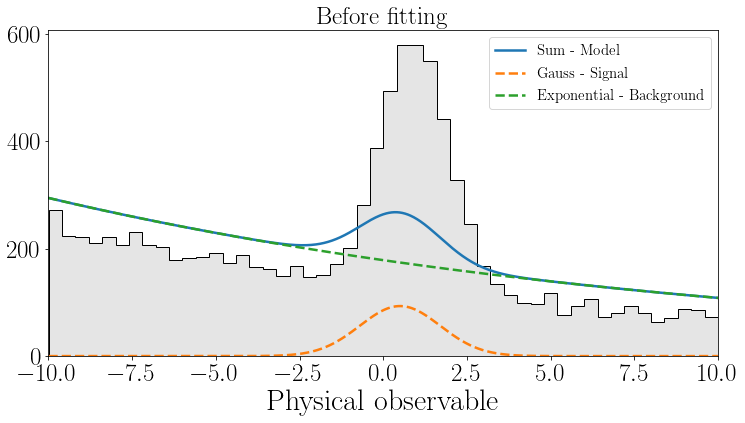

In [9]:
data_np = data[:, 0].numpy() # 1D-array of values

# Parameters of the fit:
color = 'black'
n_bins = 50
linewidth = 2.5
plot_scaling = (n_sample / n_bins) * obs.area() # = number of elements in each bin * size of the bin
# obs.area(): Return the total area of all the limits and axes. Useful, for example, for MC integration.
# ---> obs.area = high-low = 20
# We'll multiply by plot_scaling the pdf
# pdf is such that when integrated from -infty to +infty, =1
# * n_sample / n_bins --> normalisation
# but why * obs.area() ???



fig, ax = plt.subplots(figsize=(12,6))
plt.title("Before fitting",fontsize=25)

## plot the data (edge + fill with a color)
plt.hist(data_np, color=color, bins=n_bins, histtype="stepfilled", alpha=0.1)
plt.hist(data_np, color=color, bins=n_bins, histtype="step")

## plot the pdfs
x = np.linspace(low, high, 1000)

# 
y = model.pdf(x).numpy() # after fit

y_gauss = (gauss.pdf(x) * frac).numpy()  # notice the frac!
y_exp = (exponential.pdf(x) * (1 - frac)).numpy()  # notice the frac!

plt.plot(x, y * plot_scaling, label="Sum - Model", linewidth=linewidth)
plt.plot(x, y_gauss * plot_scaling, '--', label="Gauss - Signal", linewidth=linewidth)
plt.plot(x, y_exp * plot_scaling, '--', label="Exponential - Background", linewidth=linewidth)
plt.xlim(low,high)
plt.xlabel("Physical observable",fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.legend(fontsize=15)
plt.show()

Now let's do some fitting with zfit. We create a negative log-likelihood (`nll`), which is based on our total PDF (`model`) and toy dataset (`data`).

In [10]:
# create NLL (associated to the model and data)
nll = zfit.loss.UnbinnedNLL(model=model, data=data)

Now we set up a `Minuit` minimiser, and give the `nll` to it. This tells `Minuit` to minimise the negative lo-likelihood of `model` with respect to `data`, in other words to do a maximum likelihood fit.  

In [19]:
# create a minimizer
minimizer = zfit.minimize.Minuit()
# minimise with nll the model with the data
result = minimizer.minimize(nll)

# do the error calculations, here with Hesse
param_hesse = result.hesse() # get he hessien
param_errors, _ = result.errors(method='minuit_minos') # get the errors (gaussian)
print(result.params)

------------------------------------------------------------------
| FCN = 2.818e+04               |      Ncalls=53 (53 total)      |
| EDM = 4.57e-09 (Goal: 0.001)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
name         value    minuit_hesse         minuit_minos    at limit
--------  --------  --------------  -------------------  ----------
fraction    0.2965     +/-  0.0068  - 0.0068   + 0.0068     

Info: VariableMetricBuilder: no improvement in line search


- FCN: number to minimise
- EDM: estimated vertical distance remaining to minimum

The fit has now run, and returned us values for the various parameters as well as their uncertainties. How do they compare to the values we initially used to generate the toy dataset?

We can look at how our PDF compares to the data now we have run our fit:

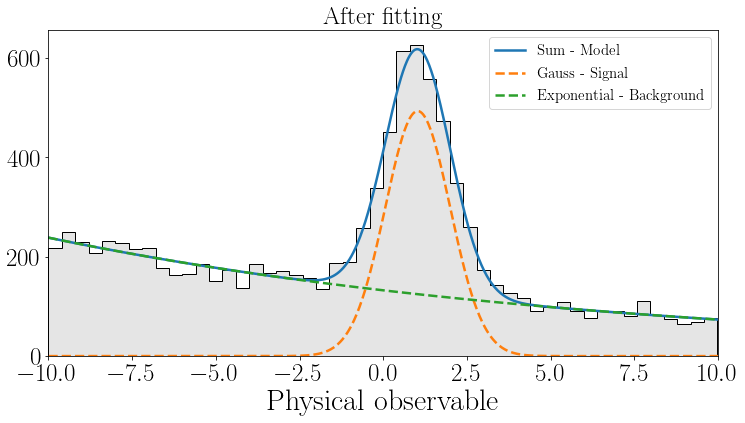

In [13]:
fig, ax = plt.subplots(figsize=(12,6))
plt.title("After fitting",fontsize=25)
# plot the data
plt.hist(data_np, color=color, bins=n_bins, histtype="stepfilled", alpha=0.1)
plt.hist(data_np, color=color, bins=n_bins, histtype="step")
# plot the pdfs
y = model.pdf(x).numpy()
y_gauss = (gauss.pdf(x) * frac).numpy()  # notice the frac!
y_exp = (exponential.pdf(x) * (1 - frac)).numpy()  # notice the frac!

plt.plot(x, y * plot_scaling, label="Sum - Model", linewidth=linewidth)
plt.plot(x, y_gauss * plot_scaling, '--', label="Gauss - Signal", linewidth=linewidth)
plt.plot(x, y_exp * plot_scaling, '--', label="Exponential - Background", linewidth=linewidth)
plt.xlim(low,high)
plt.xlabel("Physical observable",fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.legend(fontsize=15)
plt.show()

The fit has found best values for the various parameters, and as a result the total PDF now agrees very well with the toy dataset.

**Follow-up tasks**
- Can you apply the methods here to fit the $B^0 \to D^{*-} \pi^+ \pi^+ \pi^-$ signal MC sample? Will you need a background model for that fit?
- Can you fit the data using a similar fit to the one above? Remember, we want to measure the normalisation yield rather than a signal fraction, so you need to get the fit to measure an `n_sig` and `n_bkg`. Look at the "Signal-background-mass fit extended" options in the `zfit` examples.

## Task 1 - Can you apply the methods here to fit the ùêµ0‚Üíùê∑‚àó‚àíùúã+ùúã+ùúã‚àí signal MC sample? Will you need a background model for that fit?

We only need the signal one.

In [14]:
from bd2dst3pi.locations import loc
from bd2dst3pi.definitions import years, magnets

def load_data(years,magnets,type_data = 'data', vars = ['*']):
    """
    type_data = 'MC', 'data', 'data_strip', 'ws_strip'
    """
    tree_name = "DecayTree"
    if type_data == 'MC':
        path = f"{loc.MC}/Bd_Dst3pi_11266018"
        ext = '_Sim09e-ReDecay01.root'
    elif type_data == 'data':
        path = f"{loc.DATA}/data_90000000"
        ext = '.root'
    elif type_data == 'MCc':
        path = f"{loc.MC}/Bd_Dst3pi_11266018"
        ext = '_Sim09c-ReDecay01.root'
    elif type_data == 'MCe':
        path = f"{loc.MC}/Bd_Dst3pi_11266018"
        ext = '_Sim09e-ReDecay01.root'
    elif type_data == 'data_strip':
        path = f"{loc.DATA_STRIP}/data_90000000"
        ext = '.root'
        tree_name = "DecayTreeTuple/DecayTree"
    elif type_data == 'ws_strip':
        path = f"{loc.DATA_WS_STRIP}/dataWS_90000000"
        ext = '.root'
        tree_name = "DecayTreeTuple/DecayTree"
    else:
        print("Possible type of data: 'MC', 'data', 'data_strip', 'ws_strip'")
    
    dfr = {}
    dfr_tot = pd.DataFrame()
    for y in years:
        for m in magnets:
            print(f"{path}_{y}_{m}{ext}")
            dfr[f"{y}_{m}"] = read_root(f"{path}_{y}_{m}{ext}",tree_name, columns=vars)
            
            dfr_tot = dfr_tot.append(dfr[f"{y}_{m}"])
    return dfr, dfr_tot

In [15]:
_, df_tot = load_data(years,magnets,type_data = 'MC',vars = ['B0_M'])

/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//norm/Bd_Dst3pi/Bd_Dst3pi_11266018_2015_up_Sim09e-ReDecay01.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//norm/Bd_Dst3pi/Bd_Dst3pi_11266018_2015_down_Sim09e-ReDecay01.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//norm/Bd_Dst3pi/Bd_Dst3pi_11266018_2016_up_Sim09e-ReDecay01.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//norm/Bd_Dst3pi/Bd_Dst3pi_11266018_2016_down_Sim09e-ReDecay01.root


In [16]:
def plot_hist(data,name_var,unit_var, low=None,high=None, n_bins = 50, color = 'black'):
    
    if low is None:
        low = float(data.min())
    if high is None:
        high = float(data.max())
    
    name_var = name_var.replace('_','\_')

    fig, ax = plt.subplots(figsize=(12,6))
    plt.hist(data, color=color, bins=n_bins, range=(low,high), histtype="stepfilled", alpha=0.1)
    plt.hist(data, color=color, bins=n_bins, range=(low,high), histtype="step")
    
    bin_width = float((high-low)/n_bins)
    plt.xlabel(f"{name_var} [{unit_var}]",fontsize=25)
    plt.ylabel(f"Candidates / ({bin_width:.1g} {unit_var})",fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=20)
    #plt.legend(fontsize=15)
    plt.tight_layout()
    plt.show()


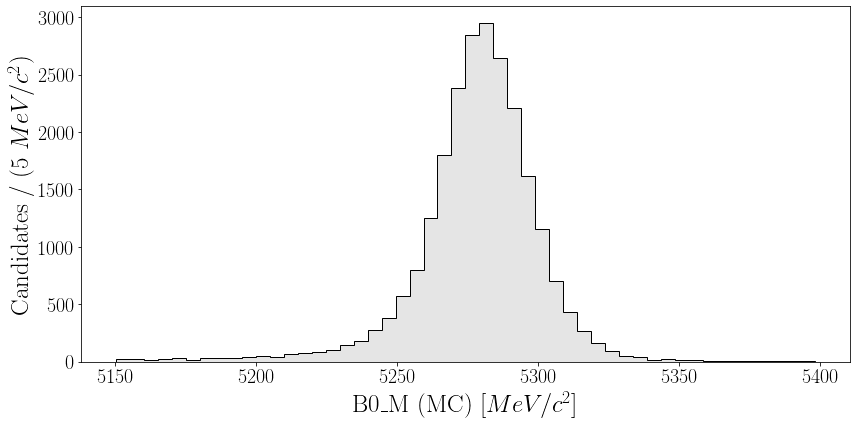

In [17]:
plot_hist(df_tot,'B0_M (MC)','$MeV/c^2$', n_bins = 50)   

In [18]:
low = 5150
high = 5400
obs = zfit.Space("x", limits=(low, high))

In [19]:
# mass B0: 5,279.53
mu_MC = zfit.Parameter("mu_MC", 5280, 5250, 5300)
sigma_MC = zfit.Parameter("sigma_MC", 50, 10, 100)

In [20]:
sigma_MC.set_value(20)

In [21]:
gauss_MC = zfit.pdf.Gauss(mu=mu_MC, sigma=sigma_MC, obs=obs)

In [22]:
data = zfit.Data.from_pandas(df_tot,obs=obs)
nll = zfit.loss.UnbinnedNLL(model=gauss_MC, data=data)

In [23]:
# create a minimizer
minimizer = zfit.minimize.Minuit()
# minimise with nll the model with the data
result = minimizer.minimize(nll)

# do the error calculations, here with Hesse
param_hesse = result.hesse() # get he hessien
param_errors, _ = result.errors(method='minuit_minos') # get the errors (gaussian)
print(result.params)

------------------------------------------------------------------
| FCN = 1.069e+05               |      Ncalls=30 (30 total)      |
| EDM = 7.99e-05 (Goal: 0.001)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
name        value    minuit_hesse         minuit_minos    at limit
--------  -------  --------------  -------------------  ----------
mu_MC        5279     +/-    0.14  -   0.14   +   0.14       F

In [24]:
def plot_hist_fit(data,name_var,unit_var,model = None, obs= None, low = None, high = None, n_bins = 50, color = 'black', 
                  linewidth = 2.5):
    name_var = name_var.replace('_','\_')
    fig, ax = plt.subplots(figsize=(12,6))

    if low is None:
        low = float(data.min())
    if high is None:
        high = float(data.max())

    h,_,_ = plt.hist(data, color=color, range = (low,high), bins=n_bins, histtype="stepfilled", alpha=0.1)
    plt.hist(data, color=color, range = (low,high),  bins=n_bins, histtype="step")

    bin_width = float((high-low)/n_bins)
    plt.xlabel(f"{name_var} [{unit_var}]",fontsize=25)
    plt.ylabel(f"Candidates / ({bin_width:.1g} {unit_var})",fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=20)
    
    if model is not None:
        plot_scaling = h.sum() * obs.area() / n_bins 
        x = np.linspace(low, high, 1000)
        y = model.pdf(x).numpy()
        plt.plot(x, y * plot_scaling, linewidth=linewidth)
    
    plt.tight_layout()
    plt.show()


n_bins 50
len(data) 23692
area tf.Tensor([250.], shape=(1,), dtype=float64)


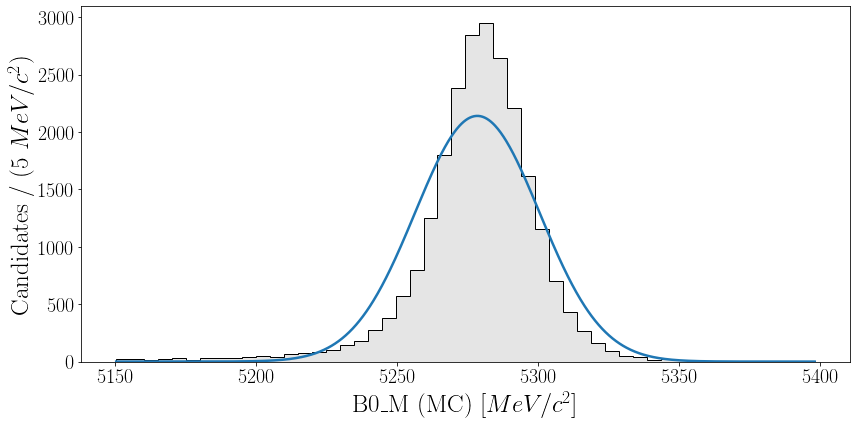

In [25]:
plot_hist_fit(df_tot, 'B0_M (MC)','$MeV/c^2$', obs = obs, model = gauss_MC, n_bins = 50)   

You can try to fit (for fun) with a double Crystall Ball PDF, using the function

    zfit.pdf.DoubleCB(mu, sigma, alphal, nl, alphar, nr, obs, name='DoubleCB', dtype=tf.float64)

In [26]:
alphaL_MC = zfit.Parameter("alphaL_MC", 2., 0.1, 5.)
alphaR_MC = zfit.Parameter("alphaR_MC", 2., 0.1, 5.)
nL_MC = zfit.Parameter("nL_MC", 2., 0.01, 10.)
nR_MC = zfit.Parameter("nR_MC", 2., 0.01, 10.)

In [27]:
doubleCB_MC = zfit.pdf.DoubleCB(mu_MC, sigma_MC, alphaL_MC, alphaR_MC, nL_MC, nR_MC, obs=obs)

In [28]:
nll_doubleCB = zfit.loss.UnbinnedNLL(model=doubleCB_MC, data=data)

In [29]:
# create a minimizer
minimizer = zfit.minimize.Minuit()
# minimise with nll the model with the data
result = minimizer.minimize(nll_doubleCB)

# do the error calculations, here with Hesse
param_hesse = result.hesse() # get the hessien
param_errors, _ = result.errors(method='minuit_minos') # get the errors (gaussian)
print(result.params)

------------------------------------------------------------------
| FCN = 1.04e+05                |     Ncalls=299 (299 total)     |
| EDM = 0.00031 (Goal: 0.001)   |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
name         value    minuit_hesse         minuit_minos    at limit
---------  -------  --------------  -------------------  ----------
alphaL_MC    1.534     +/-   0.041  -  0.043   +  0.044     

n_bins 50
len(data) 23692
area tf.Tensor([250.], shape=(1,), dtype=float64)


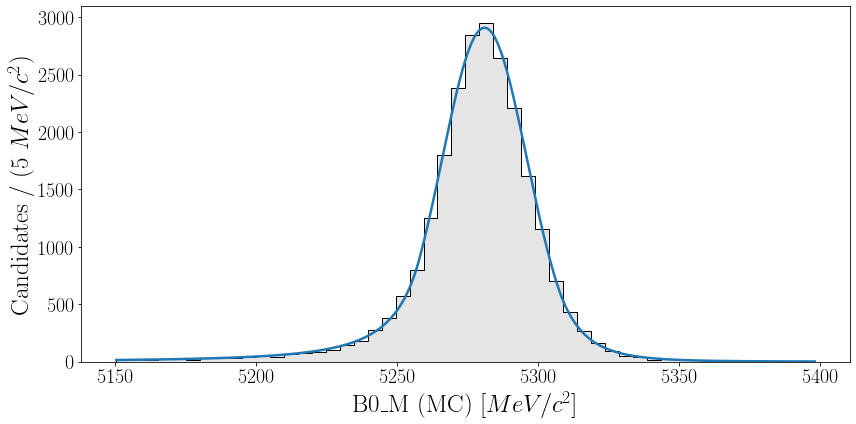

In [30]:
plot_hist_fit(df_tot, 'B0_M (MC)','$MeV/c^2$',model = doubleCB_MC, obs = obs, n_bins = 50)   

## Task 2 - Can you fit the data using a similar fit to the one above? Remember, we want to measure the normalisation yield rather than a signal fraction, so you need to get the fit to measure an `n_sig` and `n_bkg`. Look at the "Signal-background-mass fit extended" options in the `zfit` examples.

In [31]:
vars = ["B0_M","Dst_M","D0_M"]

In [32]:
_, df_data_strip = load_data(years,magnets,type_data = 'data_strip',vars = vars)

/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//stripped/data/data_90000000_2015_up.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//stripped/data/data_90000000_2015_down.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//stripped/data/data_90000000_2016_up.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//stripped/data/data_90000000_2016_down.root


In [33]:
#_, df_ws_strip = load_data(years,magnets,type_data = 'ws_strip',vars = vars)

In [34]:
len(df_data_strip)

8162450

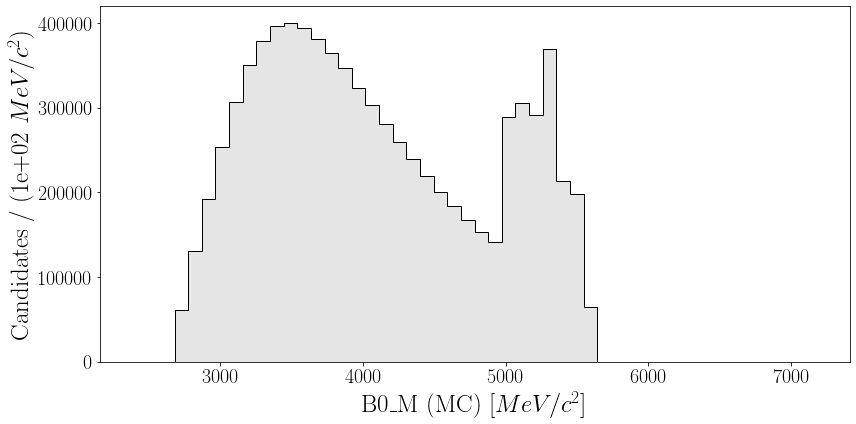

In [35]:
plot_hist(df_data_strip['B0_M'],'B0_M (MC)','$MeV/c^2$', n_bins = 50)   

In [36]:
df_data_strip["Delta_M"] = df_data_strip["Dst_M"] - df_data_strip["D0_M"]
df_data_strip = df_data_strip.query("Delta_M > 143. and Delta_M < 148.")

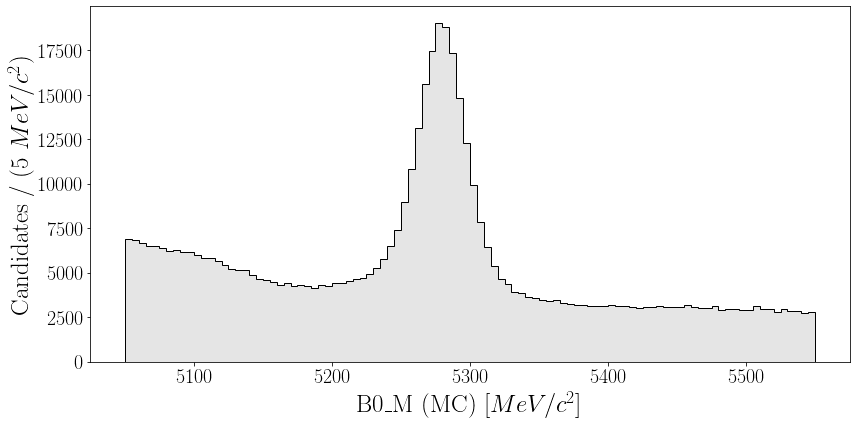

In [37]:
low = 5050.
high = 5550.
plot_hist(df_data_strip['B0_M'],'B0_M (MC)','$MeV/c^2$',low,high, n_bins = 100)   

Variables

In [38]:
low = 5050.
high = 5550.
obs_d = zfit.Space("x", limits=(low, high))

In [39]:
n_bkg = zfit.Parameter('n_bkg', len(df_data_strip)*9/10,0,len(df_data_strip))
n_sig = zfit.Parameter('n_sig', len(df_data_strip)*2/10,0,len(df_data_strip))

mu_d = zfit.Parameter("mu_d", 5280, 5250, 5300)
sigma_d = zfit.Parameter("sigma_d", 50, 10, 100)
lambd_d = zfit.Parameter("lambda_d", -0.06, -1, -0.001)

In [40]:
gauss_d = zfit.pdf.Gauss(mu=mu_d, sigma=sigma_d, obs=obs_d)
exponential_d = zfit.pdf.Exponential(lambd_d, obs=obs_d)
# sum of the two PDFs
gauss_ext_d = gauss_d.create_extended(n_sig)
exp_ext_d = exponential_d.create_extended(n_bkg)
model_d = zfit.pdf.SumPDF([gauss_ext_d, exp_ext_d]) # gauss is folded by frac

In [41]:
data_d = zfit.Data.from_pandas(df_data_strip['B0_M'],obs=obs_d)
nll_d = zfit.loss.ExtendedUnbinnedNLL(model=model_d, data=data_d)
# create a minimizer
minimizer = zfit.minimize.Minuit()
# minimise with nll the model with the data
result = minimizer.minimize(nll_d)

# do the error calculations, here with Hesse
param_hesse = result.hesse() # get he hessien
param_errors, _ = result.errors(method='minuit_minos') # get the errors (gaussian)
print(result.params)

------------------------------------------------------------------
| FCN = -3.312e+06              |     Ncalls=419 (419 total)     |
| EDM = 0.000312 (Goal: 0.001)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
name          value    minuit_hesse         minuit_minos    at limit
--------  ---------  --------------  -------------------  ----------
n_sig        129600     +/- 4.9e+02  -4.8e+02   +4.9e+02  

n_bins 50
len(data) 2955949
area tf.Tensor([500.], shape=(1,), dtype=float64)


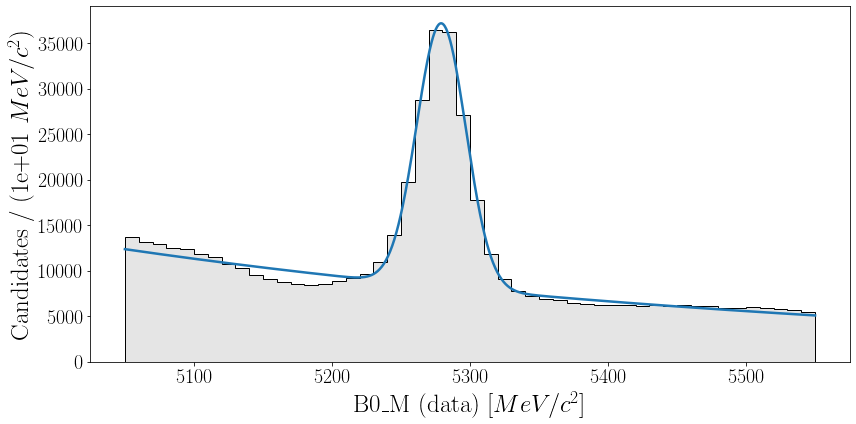

In [42]:
plot_hist_fit(df_data_strip['B0_M'], 'B0_M (data)','$MeV/c^2$',model_d, obs_d, low, high, n_bins = 50)   

We could try to use a double CB (fun)

In [43]:
low = 5050.
high = 5550.

mu_dCB = zfit.Parameter("mu_dCB", 5280, 5275., 5285.)
sigma_dCB = zfit.Parameter("sigma_dCB", 20., 15., 25.)

alphaL_d = zfit.Parameter("alphaL_d", 10., 0.1, 20.)
alphaR_d = zfit.Parameter("alphaR_d", 10., 0.1, 20.)
nL_d = zfit.Parameter("nL_d", 10., 0.001, 20.)
nR_d = zfit.Parameter("nR_d", 10., 0.001, 20.)

In [44]:
#alphaL_d.set_value(0.5)
#alphaR_d.set_value(0.5)
#nL_d.set_value(2.)
#nR_d.set_value(2.)

#mu_dCB.set_value(float(mu_d))
#sigma_dCB.set_value(18)

In [45]:
n_bkgCB = zfit.Parameter('n_bkgCB', len(df_data_strip)*8/10,0,len(df_data_strip))
n_sigCB = zfit.Parameter('n_sigCB', len(df_data_strip)*2/10,0,len(df_data_strip))

In [46]:
lambd_dCB = zfit.Parameter("lambda_dCB", -0.06, -1, -0.0001)

In [47]:
n_bkgCB.set_value(float(n_bkg))
n_sigCB.set_value(float(n_sig))
#lambd_dCB.set_value(float(lambd_d))

In [48]:
doubleCB_d = zfit.pdf.DoubleCB(mu_dCB, sigma_dCB, alphaL_d, alphaR_d, nL_d, nR_d, obs=obs_d)
exponential_dCB = zfit.pdf.Exponential(lambd_dCB, obs=obs_d)
# sum of the two PDFs
doubleCB_ext_d = doubleCB_d.create_extended(n_sigCB)
exp_ext_dCB = exponential_dCB.create_extended(n_bkgCB)
model_dCB = zfit.pdf.SumPDF([doubleCB_ext_d, exp_ext_dCB]) # gauss is folded by frac

In [49]:
nll_dCB = zfit.loss.ExtendedUnbinnedNLL(model=model_dCB, data=data_d)
# create a minimizer
minimizer = zfit.minimize.Minuit()
# minimise with nll the model with the data
result = minimizer.minimize(nll_dCB)

# do the error calculations, here with Hesse
param_hesse = result.hesse() # get he hessien
param_errors, _ = result.errors(method='minuit_minos') # get the errors (gaussian)
print(result.params)

------------------------------------------------------------------
| FCN = -3.312e+06              |     Ncalls=282 (282 total)     |
| EDM = 7.28e-07 (Goal: 0.001)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
name            value    minuit_hesse         minuit_minos    at limit
----------  ---------  --------------  -------------------  ----------
n_sigCB        129600     +/- 4.9e+02  -4.9e+02   +4.9

n_bins 50
len(data) 2955949
area tf.Tensor([500.], shape=(1,), dtype=float64)


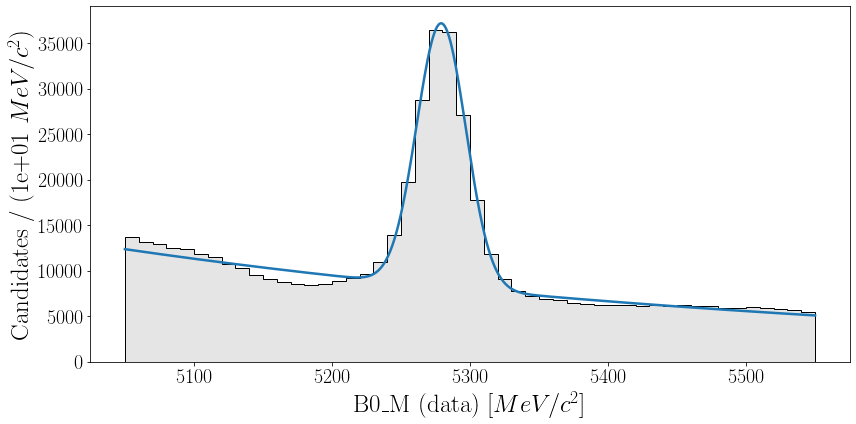

In [60]:
plot_hist_fit(df_data_strip['B0_M'], 'B0_M (data)','$MeV/c^2$',model_dCB, obs_d, low, high, n_bins = 50)   

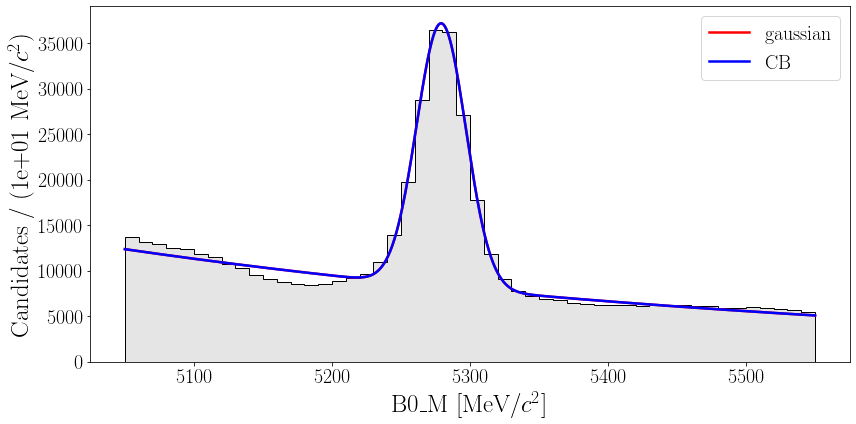

In [63]:
models = [model_dCB,model_d]
labels = ['gaussian','CB']
color = 'black'
name_var = 'B0_M'
unit_var = 'MeV/$c^2$'
name_var = name_var.replace('_','\_')
data = df_data_strip['B0_M']
low = 5050.
high = 5550.
n_bins = 50

fig, ax = plt.subplots(figsize=(12,6))


if low is None:
    low = float(data.min())
if high is None:
    high = float(data.max())
    

h,_,_ = plt.hist(data, color=color, range = (low,high), bins=n_bins, histtype="stepfilled", alpha=0.1)
plt.hist(data, color=color, range = (low,high),  bins=n_bins, histtype="step")

bin_width = float((high-low)/n_bins)
plt.xlabel(f"{name_var} [{unit_var}]",fontsize=25)
plt.ylabel(f"Candidates / ({bin_width:.1g} {unit_var})",fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=20)

colors = ['r','b']
plot_scaling = h.sum() * obs_d.area() / n_bins 
x = np.linspace(low, high, 1000)
for i,model in enumerate(models):
    y = model.pdf(x).numpy()
    plt.plot(x, y * plot_scaling, linewidth=linewidth,color=colors[i],label = labels[i])
plt.legend(fontsize = 20)
plt.tight_layout()
plt.show()
